In [1]:
from symmer.simulation import VQE_Runtime

In [3]:
import json
import numpy as np
from symmer.chem import MoleculeBuilder
from symmer.projection import QubitTapering, CS_VQE, StabilizerIdentification
from symmer.symplectic import ObservableGraph, PauliwordOp, AnsatzOp, ObservableOp

with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)    

speciesname = 'Be_STO-3G_SINGLET'
print(speciesname)
# build the molecule
mol_data = molecule_geometries[speciesname]
atoms  = mol_data['atoms']
coords = mol_data['coords']
charge = mol_data['charge']
basis = mol_data['basis']
geometry = list(zip(atoms, coords))

molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=0, run_fci=True, print_info=True)

Be_STO-3G_SINGLET
Molecule geometry:
Be	0	0	0

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -14.351880476202023
MP2 energy:  -14.376238850841515
CCSD energy: -14.403650751752787
FCI energy:  -14.403655108067682


Number of qubits: 10


In [4]:
# taper the Hamiltonian
qubit_tapering = QubitTapering(molecule.H_q)
hf_array = molecule.H_fermion.hf_comp_basis_state
qubit_tapering.stabilizers.update_sector(hf_array)
ham_tap = qubit_tapering.taper_it(ref_state=hf_array)
ucc_tap = qubit_tapering.taper_it(aux_operator=molecule.UCC_q, ref_state=hf_array) #molecule.T_q
hf_tapered = qubit_tapering.tapered_ref_state

print(f'Qubit tapering permitted a reduction of {molecule.H_q.n_qubits} -> {ham_tap.n_qubits} qubits\n')
print('The following stabilizers were identified:\n')
print(qubit_tapering.stabilizers)

Qubit tapering permitted a reduction of 10 -> 5 qubits

The following stabilizers were identified:

 1 ZIZIIZIZIZ 
 1 IZIZIZIZIZ 
 1 IIIIZZIIII 
 1 IIIIIIZZII 
 1 IIIIIIIIZZ


In [5]:
n_qubits = 3
# CS-VQE and stabilizer identification
cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
CC_stabilizers = StabilizerIdentification(ucc_tap)
S = CC_stabilizers.symmetry_basis_by_subspace_dimension(n_qubits)
ham_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False)
ucc_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False, aux_operator=ucc_tap)
ref_cs = hf_tapered[cs_vqe.free_qubit_indices]
anz_cs = AnsatzOp(ucc_cs.symp_matrix, ucc_cs.coeff_vec)

ham_cs.to_PauliSumOp

PauliSumOp(SparsePauliOp([[False, False, False, False, False, False],
               [False, False, False,  True, False, False],
               [False, False, False, False,  True, False],
               [False, False, False,  True,  True, False],
               [False, False, False, False, False,  True],
               [False, False, False,  True, False,  True],
               [False, False, False, False,  True,  True],
               [False, False, False,  True,  True,  True],
               [ True, False, False, False, False, False],
               [ True, False, False, False,  True,  True],
               [False,  True, False, False, False, False],
               [False,  True, False,  True, False,  True],
               [ True,  True, False, False, False, False],
               [ True,  True, False,  True,  True, False],
               [False, False,  True, False, False, False],
               [False, False,  True,  True,  True, False],
               [ True, False,  True, False, F

In [6]:
from symmer.symplectic import QuantumState, array_to_QuantumState
from symmer.utils import exact_gs_energy

gs_energy, gs_vec = exact_gs_energy(ham_cs.to_sparse_matrix)
gs_psi = array_to_QuantumState(gs_vec)

print(gs_psi)
print()
print(f'Contextual subspace ground state error = {gs_energy - molecule.fci_energy}')

-0.9461446877+0.0000000000j |000> +
-0.1869137323+0.0000000000j |001> +
-0.1869137323+0.0000000000j |010> +
-0.1869137323+0.0000000000j |100>

Contextual subspace ground state error = 0.0003265059338524168


In [7]:
print(anz_cs.coeff_vec)
obs = ObservableOp(ham_cs.symp_matrix, ham_cs.coeff_vec)
vqe_result = obs.VQE(
    ansatz_op=anz_cs, 
    ref_state=ref_cs
)

opt_params = vqe_result[0]['x']
print(anz_cs.coeff_vec)
vqe_result[0]['fun'] - molecule.fci_energy

[-0.09847679 -0.09847679 -0.09847679 -0.09847679 -0.09847679 -0.09847679]
[-0.09771918 -0.09771918 -0.09575265 -0.09575265 -0.09389815 -0.09389815]


0.0003265823239786414

In [8]:
operator = ham_cs

QWC_decomposition = list(
    ObservableGraph(
        operator.symp_matrix, 
        operator.coeff_vec
    ).clique_cover(
        clique_relation='QWC', 
        colouring_strategy='largest_first'
    ).values()
)
assert(sum(QWC_decomposition)==operator), 'Decomposition into QWC groups failed'

In [9]:
anz_cs

-0.098 IIY +
-0.098 ZZY +
-0.096 IYI +
-0.096 ZYZ +
-0.094 YII +
-0.094 YZZ

In [44]:
s = np.random.random(10)
np.mean(s), np.std(s), np.sqrt(np.var(s))

(0.4601464834272761, 0.30399863297895874, 0.30399863297895874)

In [46]:
from ast import operator
import numpy as np
from typing import List, Union
from scipy.optimize import minimize
from qiskit.quantum_info import Pauli, PauliTable
from qiskit.opflow import PauliSumOp, PauliOp, PauliBasisChange
from qiskit import QuantumCircuit, transpile
import mthree

class VQE_Runtime:
    """ Runtime program for performing VQE routines.

    Accepts a parametrized ansatz (QuantumCircuit) with an observable (PauliSumOp)
    or observable grouping (List[PauliSumOp]), e.g. qubitwise commuting groups that
    may be measured simultaneously. If no grouping is specified then a collecion
    of randomized bases is generated and the qubitwise commuting terms of the operator
    are decomposed in each measurement basis (classical shadows https://arxiv.org/abs/2002.08953)

    For each measurement group, a change-of-basis is implemented in-circuit so that
    only Pauli-Z measurements are necessary.

    This class facilitates the submission of batch circuit jobs to the QPU, with the
    returned measurement outcomes being used to estimate expectaton values in each
    observable group, before being summed to yield an energy estimate of the full observable.
    In the classical shadows scheme, the coefficients are corrected to allow for duplicated
    terms accross the measurement groups.

    Gradients are computed analytically via the parameter shift rule (eq.15 https://arxiv.org/abs/1906.08728).
    Such gradient calculations are expensive for large numbers of parameters; each gradient requires 2*n_params
    observable expectation value estimations, although they facilitate rapid convergence to the minimum energy 
    within the limitations of the provided ansatz.

    The VQE_Runtime.run() wraps all this within a scipy.optimize.minimize routine, returning the optimizer
    output, in addition to the interim energy, parameter and gradient values.
    """
    n_shots     = 2**12
    n_realize   = 1
    n_groups    = 5
    maxiter     = 10
    optimizer   = 'SLSQP'
    init_params = None
    opt_setting = {'maxiter':10}
    mitigate_errors = True
    
    def __init__(self,
        backend,
        user_messenger,
        ansatz: QuantumCircuit,
        observable: PauliSumOp = None,
        observable_groups: List[Union[PauliSumOp, PauliOp]] = None
    ) -> None:
        """
        Args:
            - backend (): 
                The target QPU for circuit jobs
            - user_messenger (): 
                Allows readout during computation
            - ansatz (QuantumCircuit): 
                The parametrized QuantumCircuit used in state preparation
            - observable (PauliSumOp): 
                The observable for expecation value estimation
            - observable_groups (List[PauliSumOp]): 
                Some Pauli operators may be estimated simultaneously. The grouping 
                specifies this - if None, will determine a random grouping.
        """
        self.backend = backend
        self.user_messenger = user_messenger
        self.ansatz = ansatz
        self.n_params = ansatz.num_parameters
        self.n_qubits = ansatz.num_qubits
        self.observable = observable
        # if no observable grouping is specified, will group by classical shadows (i.e. random measurement bases)
        if observable_groups is None:
            assert(observable is not None), 'Must provide an observable or observable grouping'
            self.observable_groups = self.prepare_classical_shadows_observable_groups()
        else:
            self.observable_groups = observable_groups

        self.circuits,self.group_data = self.prepare_qubitwise_commuting_measurement_groups()

        if self.mitigate_errors:
            #self.maps = mthree.utils.final_measurement_mapping(self.circuits)
            self.m3   = mthree.M3Mitigation(self.backend)
            self.m3.cals_from_system(range(self.n_qubits))
            
    def QWC_terms(self, basis_symp_vec):
        """ Given the symplectic representation of a measurement basis,
        determines which operator terms may be measured in this basis

        Returns:  
            QWC_observable (PauliSumOp): 
                an observable consisting of the self.observable terms 
                that qubitwise commute with the measurement basis
        """
        X_basis, Z_basis = np.hsplit(basis_symp_vec, 2)
        X_block, Z_block = np.hsplit(self.observable.primitive.table.array, 2)
        # identify the qubit positions on which there is at least one non-identity operation
        non_I = (X_block | Z_block) & (X_basis | Z_basis)
        # identift matches between the operator and basis, these indicate qubitwise commutation
        X_match = np.all((X_block & non_I) == (X_basis & non_I), axis=1)
        Z_match = np.all((Z_block & non_I) == (Z_basis & non_I), axis=1)
        # mask the terms of self.observable that qubitwise commute with the basis
        QWC_mask = X_match & Z_match
        QWC_observable = self.observable[QWC_mask]
        
        return QWC_observable

    def prepare_classical_shadows_observable_groups(self):
        """ If no grouping is explicitly specified, we generate a grouping at random.
        This is synonymous with classical shadows and can facilitate convergence on
        the energy estimate using fewer quantum measurements than full state tomography.
        
        Returns:
            - corrected_observable_groups (List[PauliSumOp]):
                An observable groupingl each group contains terms that may be measured
                simulataneously. Note duplications can occur between measurement groups,
                hence this is corrected in the coefficients of the correpsonding terms.
        """
        random_bases = np.random.randint(0,2,(self.n_groups,2*self.n_qubits), dtype=bool)
        observable_groups = [
            self.QWC_terms(basis_symp_vec) for basis_symp_vec in random_bases
        ]
        # need to account for duplicated terms accross shadow groups
        num_duplicate_terms = {term:0 for term in self.observable.primitive.table.to_labels()}
        for opgroup in observable_groups:
            for term in opgroup.primitive.table.to_labels():
                num_duplicate_terms[term]+=1

        # dividing each coefficient by the number of duplications of the 
        # corresponding Pauli term will average the energy contributions
        corrected_observable_groups = []
        for opgroup in observable_groups:
            pauli_list = opgroup.primitive.table.to_labels()
            corrected_coeff_vec = []
            for coeff, term in zip(opgroup.coeffs, pauli_list):
                corrected_coeff_vec.append(coeff/num_duplicate_terms[term])
            corrected_group_observable = PauliSumOp.from_list(
                pauli_list=zip(pauli_list, corrected_coeff_vec)
            )
            corrected_observable_groups.append(corrected_group_observable)
        
        return corrected_observable_groups

    def prepare_qubitwise_commuting_measurement_groups(self):
        """ Given the grouping scheme, each measurement group is assigned a circuit
        composed from the specified ansatz and the relevant change of basis gates.
        For efficient expectation value computation post circuit execution, we return
        a binary array representing the Z_block of the transormed group observable.

        Returns:
            - circuits (List[PauliSumOp]):
                The paramtrized circuits in each measurement basis
            - group_data (List[Tuple[np.array, np.array]]):
                The minimal observable information necessary for expectation
                value estimation per measurement group.
        """
        circuits = []
        group_data = []
        for opgroup in self.observable_groups:
            if isinstance(opgroup, PauliSumOp):
                X_block, Z_block = np.hsplit(opgroup.primitive.table.array.astype(int), 2)
                coeff_vec = opgroup.coeffs
            elif isinstance(opgroup, PauliOp):
                X_block, Z_block = np.hsplit(PauliTable(opgroup.primitive).array.astype(int), 2)
                coeff_vec = np.array([opgroup.coeff])
            else:
                raise ValueError('Unrecognized observable group type, must be PauliSumOp or PauliOp')

            new_Z_block = (X_block | Z_block)[:,::-1]  
            group_data.append([new_Z_block, coeff_vec])
            X_pos = np.einsum('ij->j', X_block)!=0
            Z_pos = np.einsum('ij->j', Z_block)!=0
            cob_group = PauliTable(np.hstack([X_pos, Z_pos])).to_labels()[0]
            cob_gates, target = PauliBasisChange().get_cob_circuit(Pauli(cob_group))
            qc = self.ansatz.compose(cob_gates.to_circuit())
            qc.measure_all()
            circuits.append(qc)

        circuits = transpile(circuits, self.backend, optimization_level=3)

        return circuits, group_data
   
    def get_counts(self, param_list: List[np.array]):
        """ Given a list of parametrizations, bind the circuits and submit to the backend
        
        Returns:
            - result (List[Dict[str:int]]):
                A list of dictionaries in which keys are binary strings and 
                their values the frequency of said measurement outcome 

        """
        bound_circuits = []
        for params in param_list:
            bound_circuits+=[qc.bind_parameters(params) for qc in self.circuits]
        
        job = self.backend.run(
            circuits = bound_circuits,
            shots=self.n_shots
        )
        result = job.result()
        raw_counts = result.get_counts()
        
        if self.mitigate_errors:
            quasis = self.m3.apply_correction(raw_counts, range(self.n_qubits))
            return quasis.nearest_probability_distribution()
        else:
            return [{binstr:freq/self.n_shots for binstr,freq in counts.items()} 
                    for counts in raw_counts] 

    def _estimate(self, countset):
        """ Given the measurment outcomes retrieved from the the backend, calculate
        the corresponding expectation values accross the measurement groups and sum

        Returns:
            expval.real (np.float):
                The expectation value of the observable
        """
        assert(len(countset)==len(self.group_data)), 'Incompatible number of counts and observables'
        expval = 0
        for (group_Z_block, coeff_vec), measurements in zip(self.group_data, countset):
            for binstr, weight in measurements.items():
                binarr = np.array([int(i) for i in binstr])
                signed = (-1)**np.einsum('ij->i', np.bitwise_and(binarr, group_Z_block))
                expval += weight*np.sum(signed*coeff_vec)
        return expval.real

    def estimate(self, x):
        """ Wraps the _estimate method, calling get_counts to submit
        the circuit jobs parametrized by the input array x
        """
        samples = []
        for sample in range(self.n_realize):
            countset = self.get_counts([x])
            energy = self._estimate(countset)
            samples.append(energy)
        return np.mean(samples), np.std(samples)
        
    def gradient(self, x):
        """ Implementation of the parameter shif rule of https://arxiv.org/abs/1906.08728 (eq.15).
        Requires 2*n_params estimation routines, hence expensive for highly parametrized circuits.
        All circuits for the gradient estimation are submitted as a batch job. For example, given
        parameters [a,b,c], the circuits submitted are of the following form:
        [
            [a+pi/4,b,c],[a,b+pi/4,c],[a,b,c+pi/4],[a-pi/4,b,c],[a,ba-pi/4,c],[a,b,ca-pi/4]
        ],
        so the returned measurement data must be split accordingly, using split_list function below.
        
        Returns:
            estimated_gradient (np.array):
                An array representing the gradient w.r.t. each parameter at the point x
        """
        def split_list(alist, wanted_parts=1):
            length = len(alist)
            return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
                    for i in range(wanted_parts) ]
        
        upper_shift_params = [x+np.pi/4*np.eye(1,self.n_params,i)[0] for i in range(self.n_params)]
        lower_shift_params = [x-np.pi/4*np.eye(1,self.n_params,i)[0] for i in range(self.n_params)]
        
        # submit all circuits for gradient estimation as a batch job to the QPU
        all_counts = self.get_counts(upper_shift_params+lower_shift_params)
        # need to split the measurement results into the relevant sets 
        upper_shift_counts, lower_shift_counts = split_list(all_counts, 2)

        upper_shift_energy = np.array([self._estimate(countset) for countset in split_list(upper_shift_counts, self.n_params)])
        lower_shift_energy = np.array([self._estimate(countset) for countset in split_list(lower_shift_counts, self.n_params)])
        
        estimated_gradient = upper_shift_energy - lower_shift_energy
        
        return estimated_gradient
    
    def run(self):
        """ Runs a scipy.optimize.minimize routine that minimizes the output of
        self.estimate, informed by self.gradient (optimizer-dependent)

        Recommended optimizers:
            - SLSQP  (gradient-descent, does not evaluate Jacobian at each iterate like BFGS or CG so is faster)
            - COBYLA (gradient-free)
        
        Returns:
            - vqe_result (Dict[str,Union[int, float, bool, array]]):
                The optimizer output
            - interim_values (Dict[str,List[Union[float, array]]]):
                The interim energy, parameter and gradient values
        """
        interim_values = {'values':[], 'stddev':[], 'params':[], 'gradients':[], 'count':0}

        if self.init_params is None:
            self.init_params = np.zeros(self.n_params)
            
        def fun(x):
            interim_values['count']+=1
            countnum = interim_values['count']
            energy, stddev = self.estimate(x)
            self.user_messenger.publish(f'Optimization step #{countnum}: energy = {energy}')
            interim_values['params'].append((interim_values['count'], x))
            interim_values['values'].append((interim_values['count'], energy))
            interim_values['stddev'].append((interim_values['count'], stddev))
            return energy

        def jac(x):
            countnum = interim_values['count']
            Delta = self.gradient(x)
            grad_norm = np.sqrt(np.sum(np.square(Delta)))
            self.user_messenger.publish(f'Optimization step #{countnum}: gradient norm = {grad_norm}')
            interim_values['gradients'].append((interim_values['count'], Delta))
            return Delta
            
        self.user_messenger.publish('Optimization commencing')
        vqe_result = minimize(
            fun=fun, 
            jac=jac,
            x0=self.init_params,
            method=self.optimizer,
            #tol=opt_tol
            options=self.opt_setting
        )
        vqe_result.success = bool(vqe_result.success) # to ensure serializable
        self.user_messenger.publish('VQE complete')
        
        return vqe_result, interim_values

In [47]:
#vqe_results, interim_values = vqe.run()

In [48]:
#vqe_results['fun'] - molecule.fci_energy

In [49]:
from qiskit import Aer
from qiskit.providers.ibmq.runtime import UserMessenger

backend = Aer.get_backend('qasm_simulator')
user_messenger = UserMessenger()
observable = ham_cs.to_PauliSumOp
observable_groups = [group.to_PauliSumOp for group in QWC_decomposition]

excitation_circuit = anz_cs.to_QuantumCircuit(bind_params=False)
ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
#ansatz.barrier()
ansatz = ansatz.compose(excitation_circuit)

ansatz.draw()
vqe = VQE_Runtime(
        backend=backend,
        user_messenger = user_messenger,
        ansatz=ansatz,
        observable=observable,
        observable_groups=observable_groups
    )

Exception ignored in: <function _TemporaryFileCloser.__del__ at 0x7f6d38650ee0>
Traceback (most recent call last):
  File "/home/tweaving/anaconda3/lib/python3.8/tempfile.py", line 440, in __del__
    self.close()
  File "/home/tweaving/anaconda3/lib/python3.8/tempfile.py", line 436, in close
    unlink(self.name)
FileNotFoundError: [Errno 2] No such file or directory: '/home/tweaving/qc-research/symmer/notebooks/draft/tmpr77zf106'


In [63]:

vqe.estimate(np.zeros(anz_cs.n_terms))

(-14.352288933437142, 0.0007838721531418178)

In [126]:
vqe.n_realize = 10
vqe.n_shots = 2**15
vqe_result, interim_values = vqe.run()

"Optimization commencing"
"Optimization step #1: energy = -14.351450746398362"
"Optimization step #1: gradient norm = 0.4344043494155183"
"Optimization step #2: energy = -14.369781923918797"
"Optimization step #3: energy = -14.403766435804632"
"Optimization step #3: gradient norm = 0.0375022187580866"
"Optimization step #4: energy = -14.403456543585696"
"Optimization step #5: energy = -14.402793346877264"
"Optimization step #6: energy = -14.402046154388415"
"Optimization step #7: energy = -14.402108639063163"
"Optimization step #8: energy = -14.404760841208198"
"Optimization step #8: gradient norm = 0.030363754231447434"
"Optimization step #9: energy = -14.401988048477318"
"Optimization step #10: energy = -14.404221011830794"
"Optimization step #11: energy = -14.402693241297731"
"Optimization step #12: energy = -14.403340568332018"
"Optimization step #13: energy = -14.401341017941728"
"Optimization step #14: energy = -14.401669068352685"
"Optimization step #15: energy = -14.40312415580

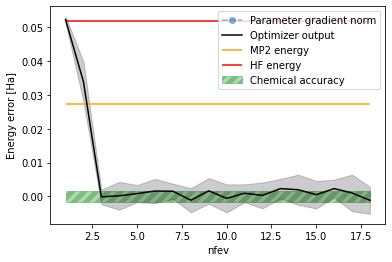

In [127]:
from matplotlib import pyplot as plt

plt.rc('hatch', color='k', linewidth=5)
fig, axis = plt.subplots()
#while not job.status().value == 'job has successfully run':
X,Y_stddev = zip(*interim_values['stddev'])
X,Y = zip(*interim_values['values'])
X,Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 1, len(X), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 1, len(X), color='red', label='HF energy')
#axis.hlines(2*0.0016, 1, len(X), color='green', label='Chemical accuracy * 2')
#axis.hlines(0.0016, 1, len(X), color='lime', label='Chemical accuracy')
#axis.hlines(-0.0016, 1, len(X), color='lime', label='Chemical accuracy')
axis.fill_between(X, -0.0016, 0.0016, alpha=0.3, color='green', label='Chemical accuracy', hatch=r"//")
axis.plot([], [], alpha=0.5, marker='o', ls='--', label='Parameter gradient norm')

Y_error = Y - molecule.fci_energy
axis.plot(X, Y_error, color='black', label='Optimizer output')
#axis.hlines(vqe_result['fun'] - molecule.fci_energy, 1, len(X), color='black', label='Converged energy', ls='--')
plt.fill_between(X, Y_error - Y_stddev, Y_error + Y_stddev, alpha=0.2, color='black')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
#axis.set_yscale('log')

#try:
#    axis_param = axis.twinx()
#    X_grad, Y_grads = zip(*interim_values['gradients'])
#    Y_grad_norm = [np.sqrt(np.sum(np.square(grad))) for grad in Y_grads]
#    axis_param.plot(X_grad, Y_grad_norm, alpha=0.5, marker='o', ls='--')
#    axis_param.set_ylabel('Parameter gradient norm $||\Delta||$')
    #for param_grad in zip(*Y_grads):
    #    axis_param.plot(X_grad, param_grad, alpha=0.2)
#except:
#    pass

axis.legend()
plt.show()

In [75]:
Y_stddev

(0.0025191553108652107,
 0.011938150805230995,
 0.013088809136778599,
 0.010471294916158643,
 0.010618246959922233,
 0.009341842945951764,
 0.00820000893378658,
 0.010668830601629384,
 0.008251752706938042,
 0.008969684562567928,
 0.009483606959464255,
 0.010978868193304804)

In [18]:
from qiskit import Aer
from qiskit.providers.ibmq.runtime import UserMessenger

ansatz_pool = anz_cs
obs = ObservableOp(ham_cs.symp_matrix, ham_cs.coeff_vec)

backend = Aer.get_backend('qasm_simulator')
user_messenger = UserMessenger()
observable = ham_cs.to_PauliSumOp
observable_groups = [group.to_PauliSumOp for group in QWC_decomposition]

n_shots = 2**12
ansatz = AnsatzOp(['I'*ham_cs.n_qubits], [0])
error = 1
cycle = 0
max_cycles = 15# ansatz_pool.n_terms

def get_ansatz_circuit(base, ref):
    excitation_circuit = base.to_QuantumCircuit(bind_params=False)
    ansatz = QuantumCircuit(n_qubits)
    for i in np.where(ref)[0]:
        ansatz.x(n_qubits-1-i)
    #ansatz.barrier()
    ansatz = ansatz.compose(excitation_circuit)
    return ansatz

while abs(error)>0.0016 and cycle<max_cycles:
    cycle+=1
    message = f'*** ADAPT cycle {cycle} ***'
    print('*'*len(message)); print(message); print('*'*len(message))
    
    gradients = []
    for index, term in enumerate(ansatz_pool):
        ansatz_temp = ansatz + term
        ansatz_temp.coeff_vec[-1]=0
        ansatz_temp = AnsatzOp(ansatz_temp.symp_matrix, ansatz_temp.coeff_vec)
        vqe = VQE_Runtime(backend=backend,user_messenger = user_messenger,
            observable=observable,observable_groups=observable_groups,
            ansatz=get_ansatz_circuit(ansatz_temp, ref_cs)
        )
        vqe.n_shots = n_shots
        upper = ansatz_temp.coeff_vec.copy()
        lower = ansatz_temp.coeff_vec.copy()
        upper[-1] = np.pi/4
        lower[-1] = -np.pi/4
        
        Delta = vqe.estimate(upper) - vqe.estimate(lower)
        print(f'{index+1}/{ansatz_pool.n_terms}: Δ={Delta}')
        gradients.append((term, Delta))
    new_term, new_Delta = sorted(gradients, key=lambda x:-abs(x[1]))[0]
    ansatz_pool -= new_term
    ansatz += new_term
    ansatz = AnsatzOp(ansatz.symp_matrix, ansatz.coeff_vec)
    
    print()
    vqe = VQE_Runtime(backend=backend,user_messenger = user_messenger,
        observable=observable,observable_groups=observable_groups,
        ansatz=get_ansatz_circuit(ansatz, ref_cs)
        )
    vqe.n_shots = n_shots
    vqe.n_realize = 5
    vqe.init_params=ansatz.coeff_vec
    vqe_result, interm_results = vqe.run()
    print()
    
    error = vqe_result['fun'] - molecule.fci_energy
    print(f'ADAPT cycle {cycle: <2} error = {error}')
    print()

*********************
*** ADAPT cycle 1 ***
*********************
1/6: Δ=0.1667552495734661
2/6: Δ=0.14728598552009586
3/6: Δ=0.2126304528078311
4/6: Δ=0.180126955407653
5/6: Δ=0.15863791687577233
6/6: Δ=0.16358748620824848

"Optimization commencing"
"Optimization step #1: energy = -14.36751076499694"
"Optimization step #1: gradient norm = 0.13149904709776017"
"Optimization step #2: energy = -14.375620067867606"
"Optimization step #2: gradient norm = 0.025557117048492728"
"Optimization step #3: energy = -14.369215937038922"
"Optimization step #4: energy = -14.374037494736402"
"Optimization step #5: energy = -14.371586320425994"
"Optimization step #6: energy = -14.373868850741228"
"Optimization step #7: energy = -14.366396002019817"
"Optimization step #8: energy = -14.373340135725865"
"Optimization step #9: energy = -14.372424528192564"
"Optimization step #10: energy = -14.375315593703297"
"Optimization step #11: energy = -14.379130061404648"
"VQE complete"

ADAPT cycle 1  error = 0.024

IndexError: list index out of range

In [61]:
ansatz

0.008 IYX +
0.008 ZXY +
-0.008 XZY +
-0.029 XXY

In [70]:
vqe = VQE_Runtime(
        backend=backend,
        user_messenger = user_messenger,
        ansatz=get_ansatz_circuit(ansatz, ref_cs),
        observable=observable,
        observable_groups=observable_groups
    )
vqe.n_shots = 2**17
vqe.init_params=ansatz.coeff_vec
vqe_result, interm_results = vqe.run()
error = vqe_result['fun'] - molecule.fci_energy
print(f'Error {error}')

/tmp/ipykernel_73142/2369120349.py:161: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  X_block, Z_block = np.hsplit(opgroup.primitive.table.array.astype(int), 2)


"Optimization commencing"
"Optimization step #1: energy = -455.15579298208644"
"Optimization step #1: gradient norm = 0.005949025100090213"
"Optimization step #2: energy = -455.15359158949576"
"Optimization step #3: energy = -455.15497009863805"
"Optimization step #4: energy = -455.1550037646699"
"Optimization step #5: energy = -455.15439917729753"
"Optimization step #6: energy = -455.15509000031335"
"Optimization step #7: energy = -455.1542917959254"
"Optimization step #8: energy = -455.15671854335426"
"VQE complete"
Error 0.0003482497948539276


In [69]:
print(ansatz)

vqe_result, interim = obs.VQE(
    ansatz_op=ansatz, 
    ref_state=ref_cs
)

error = vqe_result['fun'] - molecule.fci_energy
print(error)

0.016 IYX +
0.015 ZXY +
-0.030 XZY +
-0.120 XXY
0.0023010277520825184


In [58]:
ansatz_pool = anz_cs
obs = ObservableOp(ham_cs.symp_matrix, ham_cs.coeff_vec)

ansatz = AnsatzOp(['I'*ham_cs.n_qubits], [0])
error = 1
cycle = 0
max_cycles = ansatz_pool.n_terms

while error>0.0016 and cycle<max_cycles:
    cycle+=1
    gradients = []
    for term in ansatz_pool:
        ansatz_temp = ansatz + term
        ansatz_temp.coeff_vec[-1]=0
        ansatz_temp = AnsatzOp(ansatz_temp.symp_matrix, ansatz_temp.coeff_vec)
        
        
        Delta = obs.parameter_shift_at_index(
            ansatz_op=ansatz_temp, 
            ref_state=ref_cs,
            param_index=-1)
        gradients.append((term, Delta))
    
    new_term, new_Delta = sorted(gradients, key=lambda x:-abs(x[1]))[0]
    ansatz_pool -= new_term
    ansatz += new_term
    ansatz = AnsatzOp(ansatz.symp_matrix, ansatz.coeff_vec)
    
    vqe_result = obs.VQE(
        ansatz_op=ansatz, 
        ref_state=ref_cs
    )
    
    error = vqe_result[0]['fun'] - molecule.fci_energy
    print(f'ADAPT cycle {cycle: <2} error {error}')

ADAPT cycle 1  error 0.0055552837264940536
ADAPT cycle 2  error 0.0038404180708653257
ADAPT cycle 3  error 0.002315015469832815
ADAPT cycle 4  error 0.002283532913736508
ADAPT cycle 5  error 0.0022738447047458976
ADAPT cycle 6  error 0.0022701327917502567
ADAPT cycle 7  error 0.0022680790741560486
ADAPT cycle 8  error 0.0022701204187001167
ADAPT cycle 9  error 0.0022697071184438755
ADAPT cycle 10 error 0.0008374117596758879


In [33]:
ansatz

-0.026 ZZY +
0.039 IXY +
0.027 IYX +
0.015 ZXY +
0.034 ZYX +
-0.001 XIY +
0.012 XZY +
0.011 YIX +
-0.007 YZX +
-0.134 XXY

In [177]:
op = anz_cs[3].to_PauliSumOp
print(op)
op.exp_i()

(-0.09575265353299389+0j) * ZYZ


EvolvedOp(PauliOp(Pauli('ZYZ'), coeff=(-0.09575265353299389+0j)), coeff=1.0)

In [202]:
from qiskit.extensions import HamiltonianGate
from qiskit.circuit import Parameter
block = HamiltonianGate(op, 0.1)

In [203]:
qc = QuantumCircuit(n_qubits)

In [204]:
qc.append(block, range(n_qubits))

In [210]:
qc.decompose().decompose().decompose().decompose().decompose().draw()

┌────────────────┐┌────────────┐┌───┐┌────────────┐┌───┐┌────────────┐»
q_0: ┤0               ├┤ unitary_dg ├┤ X ├┤ unitary_dg ├┤ X ├┤ unitary_dg ├»
     │                │└────────────┘└─┬─┘└────────────┘└─┬─┘└────────────┘»
q_1: ┤1 circuit-17981 ├────────────────■──────────────────┼────────────────»
     │                │                                   │                »
q_2: ┤2               ├───────────────────────────────────■────────────────»
     └────────────────┘                                                    »
«     ┌───┐┌────────────┐┌───────────────────┐┌────────────┐┌───┐┌────────────┐»
«q_0: ┤ X ├┤ unitary_dg ├┤1                  ├┤ unitary_dg ├┤ X ├┤ unitary_dg ├»
«     └─┬─┘└────────────┘│                   │└────────────┘└─┬─┘└────────────┘»
«q_1: ──■────────────────┤0 circuit-17884_dg ├────────────────■────────────────»
«                        │                   │                                 »
«q_2: ───────────────────┤2                  ├─────────────────────────────────»
«                        └───────────────────┘                                 »
«     ┌───┐┌────────────┐┌───┐┌────────────┐┌────────────┐              ┌───┐»
«q_0: ┤ X ├┤ unitary_dg ├┤ X ├┤ unitary_dg ├┤ unitary_dg ├──────────────┤ X ├»
«     └─┬─┘└────────────┘└─┬─┘├────────────┤└───┬───┬────┘┌────────────┐└─┬─┘»
«q_1: ──┼──────────────────■──┤ unitary_dg ├────┤ X ├─────┤ unitary_dg ├──■──»
«       │                     └────────────┘    └─┬─┘     └────────────┘     »
«q_2: ──■─────────────────────────────────────────■──────────────────────────»
«                                                                            »
«     ┌────────────┐┌───┐┌────────────┐┌───┐┌────────────┐┌────────────┐┌───┐»
«q_0: ┤ unitary_dg ├┤ X ├┤ unitary_dg ├┤ X ├┤ unitary_dg ├┤ unitary_dg ├┤ X ├»
«     └────────────┘└─┬─┘└────────────┘└─┬─┘└────────────┘└────────────┘└─┬─┘»
«q_1: ────────────────┼──────────────────■────────────────────────────────■──»
«                     │                                                      »
«q_2: ────────────────■──────────────────────────────────────────────────────»
«                                                                            »
«     ┌────────────┐┌───┐┌────────────┐┌───┐┌────────────┐┌───────────────────┐»
«q_0: ┤ unitary_dg ├┤ X ├┤ unitary_dg ├┤ X ├┤ unitary_dg ├┤1                  ├»
«     └────────────┘└─┬─┘└────────────┘└─┬─┘└────────────┘│                   │»
«q_1: ────────────────┼──────────────────■────────────────┤0 circuit-17937_dg ├»
«                     │                                   │                   │»
«q_2: ────────────────■───────────────────────────────────┤2                  ├»
«                                                         └───────────────────┘»
«     ┌────────────┐┌───┐┌────────────┐┌───┐  ┌────────────┐  ┌───┐»
«q_0: ┤ unitary_dg ├┤ X ├┤ unitary_dg ├┤ X ├──┤ unitary_dg ├──┤ X ├»
«     └────────────┘└─┬─┘└────────────┘└─┬─┘  └────────────┘  └─┬─┘»
«q_1: ────────────────■──────────────────┼──────────────────────■──»
«                                        │  ┌────────────────┐     »
«q_2: ───────────────────────────────────■──┤ U(0,3π/8,3π/8) ├─────»
«                                           └────────────────┘     »
«     ┌────────────┐┌────────────┐              ┌───┐┌────────────┐┌───┐»
«q_0: ┤ unitary_dg ├┤ unitary_dg ├──────────────┤ X ├┤ unitary_dg ├┤ X ├»
«     ├────────────┤└───┬───┬────┘┌────────────┐└─┬─┘└────────────┘└─┬─┘»
«q_1: ┤ unitary_dg ├────┤ X ├─────┤ unitary_dg ├──■──────────────────┼──»
«     └────────────┘    └─┬─┘     └────────────┘                     │  »
«q_2: ────────────────────■──────────────────────────────────────────■──»
«                                                                       »
«     ┌────────────┐┌───┐┌────────────┐
«q_0: ┤ unitary_dg ├┤ X ├┤ unitary_dg ├
«     └────────────┘└─┬─┘└────────────┘
«q_1: ────────────────■────────────────
«                                      
«q_2: ───────────────────